In [103]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.io

dataImported = scipy.io.loadmat('old_faithful.mat')
#print data
%matplotlib inline
# the Gaussian means (as column vectors -- ie, the mean for Gaussian 0 is mus[:,0]
mus = np.asarray( [[-1.17288986, -0.11642103],
                   [-0.16526981,  0.70142713]])
 
# the Gaussian covariance matrices
covs = list()
covs.append( 
    np.asarray([[ 0.74072815,  0.09252716],
                [ 0.09252716,  0.5966275 ]]) )
covs.append( 
    np.asarray([[ 0.39312776, -0.46488887],
                [-0.46488887,  1.64990767]]) )
 
# The Gaussian mixing weights
mws = [ 0.68618439, 0.31381561 ]

data = dataImported.get("data") 

In [104]:
def cov_to_pts( cov ):
    circ = np.linspace( 0, 2*np.pi, 100 )
    sf = np.asarray( [ np.cos( circ ), np.sin( circ ) ] )
    [u,s,v] = np.linalg.svd( cov )
    pmat = u*2.447*np.sqrt(s) # 95% confidence
    return np.dot(  pmat, sf )

#Compute the responsibilities r_ik (Eq. 11.27)
def compute_responsibilities( datapoints_matrix, mu, mw, cov):
    n = mw * scipy.stats.multivariate_normal.pdf(datapoints_matrix, mean=mu, cov=cov)
    return n#build_matrix(n[0],n[1])
    
#Update the mixing weights π_k (Eq. 11.28)
def update_mixing_weights(a,b):
    return a/b
    
#Update the covariances Σk (Eq. 11.32)
def update_covariance(norm_resps, meansMatrix, mean, pik):
    total = 0
    totalRange = len (norm_resps)
    for n in xrange(totalRange):
        total += norm_resps[n] * np.atleast_2d(meansMatrix[n] - mean).T.dot(np.atleast_2d(meansMatrix[n] - mean))
    cov = total / pik
    return cov

#Update the means μk (Eq. 11.31)
def update_means(norm_resps, meansMatrix, pik):
    means = norm_resps * meansMatrix
    muX = np.sum(means[:,0])/pik
    muY = np.sum(means[:,1])/pik
    return [muX,muY]
    
def build_matrix(list1,list2):    
    builtMatrix = np.column_stack((list1, list2))
    return builtMatrix

def normalize_this_matrix(some_matrix):
    norm_matrix = some_matrix-some_matrix.mean(axis=0)
    return norm_matrix

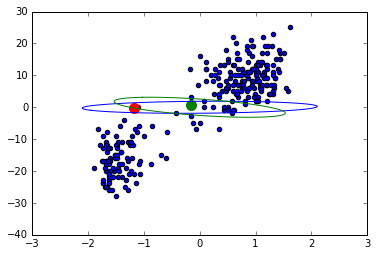

In [105]:
xvals = []
yvals = []

xvals = data[:,0]
yvals = data[:,1]

xy_matrix = build_matrix(xvals,yvals)

xy_matrix_normalized = normalize_this_matrix(xy_matrix)

covs1 = cov_to_pts(covs[0]) 
covs2 = cov_to_pts(covs[1])
plt.scatter(xy_matrix_normalized[:,0],xy_matrix_normalized[:,1])
plt.plot(covs1[0],covs1[1])
plt.plot(covs2[0],covs2[1])
plt.scatter(mus[0][0], mus[0][1], s=100, color="red")
plt.scatter(mus[1][0], mus[1][1], s=100, color="green")

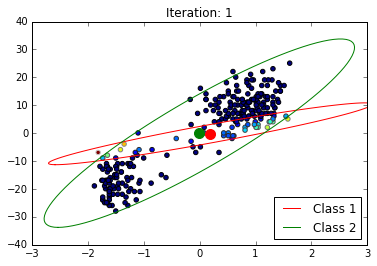

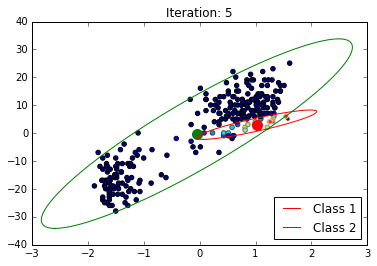

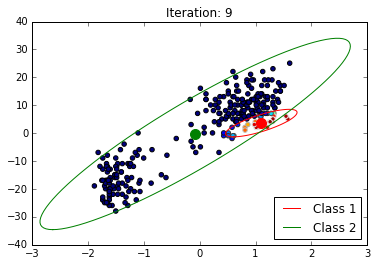

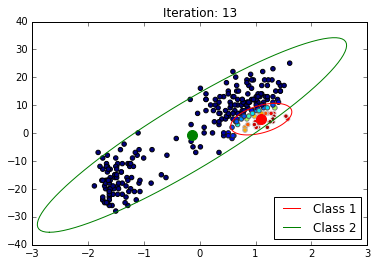

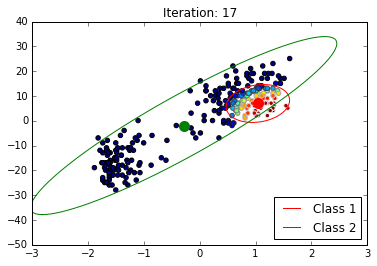

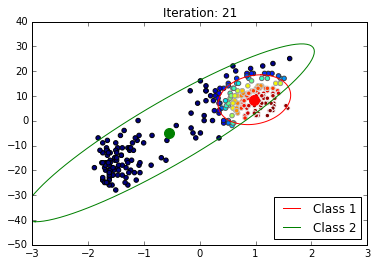

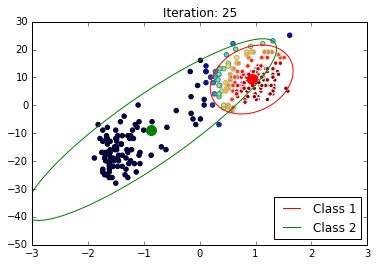

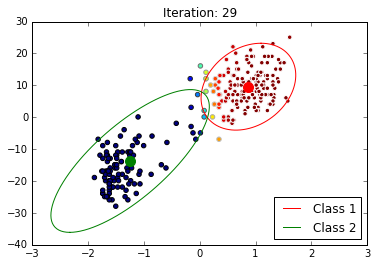

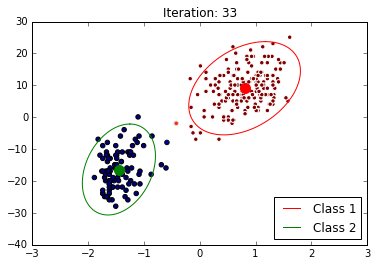

In [106]:
#run it 33 times to match pictures
for x in xrange(34): 
    totalResponsibility = 0
    responsibilities = []
    iterations = len(mws)
    for m in xrange(iterations):
        responsibility = compute_responsibilities(xy_matrix_normalized,mus[m],mws[m],covs[m] )
        responsibilities.append(responsibility)
        totalResponsibility += responsibility

    n = build_matrix(responsibilities[0]/totalResponsibility,responsibilities[1]/totalResponsibility)
    pi_ks = np.apply_along_axis(np.sum, 0, n)
    
    
    for i in xrange(iterations):
        mus[i]=update_means(np.atleast_2d(n[:,i]).T, xy_matrix_normalized, pi_ks[i] )
        covs[i]=update_covariance(np.atleast_2d(n[:,i]).T, xy_matrix_normalized, mus[i], pi_ks[i])     
        mws[i] = update_mixing_weights(pi_ks[i],len(n))      
    
    if x % 4 == 1:
        plt.title("Iteration: %d" % x)
        
        covs1 = cov_to_pts(covs[0]) 
        covs2 = cov_to_pts(covs[1])
        
        c1, = plt.plot(covs1[0] + mus[0][0], covs1[1] + mus[0][1], color="red", label="Class 1")
        c2, = plt.plot(covs2[0] + mus[1][0], covs2[1]  + mus[1][1], color="green", label="Class 2")
        plt.legend(handles=[c1, c2], loc=4)

        plt.scatter(xy_matrix_normalized[:,0],xy_matrix_normalized[:,1], color=map(str, n[:,0]))
        plt.scatter(mus[0][0], mus[0][1], s=100, color="red")
        plt.scatter(mus[1][0], mus[1][1], s=100, color="green")
        plt.xlim(-3,3)
        plt.show()
    